In [3]:
import sys
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import tensorflow as tf
from sklearn import datasets
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.svm import SVC

In [381]:
minmax_scaler = MinMaxScaler()

# Model Evaluation Class

In [382]:
class ModelEvaluation:
    """Model evaluation
    """

    def __init__(self, X, y, model_type='reg') -> None:
        """Initial

        Args:
            X (dataset): Dataset
            y (ground truth): Target
            model_type (str, optional): Type of model:
                        reg: Regression
                        clf: Classification. Defaults to 'reg'.
        """
        self.model_type = model_type
        self.X = X
        self.y = y

    def executed_time(self, model):
        """Calculate training time of model

        Args:
            model (estimator): Estimator, with method 'fit'
                                for training

        Returns:
            float: training time
        """
        start_time = time()
        model.fit(self.X, self.y)
        return time() - start_time

    def __get_regression_loss(self, model):
        pred = model.predict(self.X)
        return mean_squared_error(self.y, pred)

    def __get__classification_report(self, model):
        pred = model.predict(self.X)
        return classification_report(self.y, pred)

    def get_report(self, model):
        if self.model_type == 'reg':
            return self.__get_regression_loss(model)
        elif self.model_type == 'clf':
            return self.__get__classification_report(model)
        else:
            return "Invalid type"

    def loss_plot(self, model):
        return sns.lineplot(x=list(range(len(model.loss))), y=model.loss)


# Linear Regression


*   Dataset: house price from boston
*   Objective: implement both numerical + analytical solutions
*   PLot and check for convergence
*   Compare with Linear Regression using sklearn


1. Analytical solution: 
   $$
   \beta = (X^TX)^{-1}X^T y
   $$
   
2.   Numerical solution:

      * Loss function (MSE):
        $$
        \mathcal{L} (y, \hat{y}) = \frac{1}{N}\sum_{i=1}^N (y-\hat{y})^2
        $$

      * Update rule:
        $$
        \beta_{t+1} = \beta_t - \gamma \nabla \mathcal{L} (\beta_t)
        $$

      * Momentum: 
        $$
        \Delta \beta_{t+1} = -\gamma \nabla \mathcal{L}(\beta_{t+1}) + \alpha\Delta \beta_{t}
        $$

      * Update rule for momentum:
        $$
        \beta_{t+1} = \beta_t + \Delta \beta_{t}
        $$


In [383]:
X, y = datasets.load_boston(return_X_y=True)
X = minmax_scaler.fit_transform(X)
X = np.insert(X, 0, 1, axis=1)

## Linear Regression Class

In [384]:
import numpy as np


class LinearRegression:

    def __init__(self,
                 tol: float = 1e-3,
                 lr: float = 5e-3,
                 alpha: float = 5e-2,
                 max_iteration: int = 1000) -> None:
        """Init hyperparameters

        Args:
            tol (float, optional): tolerance. Defaults to 1e-3.
            lr (float, optional): learning rate. Defaults to 5e-3.
            alpha (float, optional): momentum coef. Defaults to 5e-2.
            max_iteration (int, optional): maximum iteration. Defaults to 1000.
        """

        self.tol = tol
        self.lr = lr
        self.alpha = alpha
        self.max_iteration = max_iteration

    def loss_function(self, X, y, beta):
        return np.mean(np.linalg.norm(y - X.dot(beta))**2)

    def get_gradient(self, X, y, beta):
        pred = X.dot(beta)
        y_diff = y - pred
        return -y_diff.dot(X) / X.shape[0]

    def fit(self, X, y):
        """Training the model

        Args:
            X (dataset): Dataset, with addition columns added
            y (target): Target
        """
        self.beta = np.random.randn(X.shape[1])
        loss = [self.loss_function(X, y, self.beta)]

        for i in range(1, self.max_iteration + 1):
            grad = self.get_gradient(X, y, self.beta)
            self.beta -= self.lr * grad
            current_loss = self.loss_function(X, y, self.beta)
            last_loss = loss[-1]
            loss.append(current_loss)
            if np.abs(last_loss - current_loss) < self.tol:
                break
        self.loss = loss

    def fit_momentum(self, X, y):
        self.beta = np.random.randn(X.shape[1])
        beta = [self.beta]
        loss = [self.loss_function(X, y, self.beta)]

        grad = self.get_gradient(X, y, self.beta)
        self.beta -= self.lr * grad
        beta.append(self.beta)

        for i in range(1, self.max_iteration + 1):
            grad = self.get_gradient(X, y, self.beta)
            last_beta = beta[-1]
            self.beta -= self.lr * grad + self.alpha * (self.beta - last_beta)
            beta.append(self.beta)
            current_loss = self.loss_function(X, y, self.beta)
            last_loss = loss[-1]
            loss.append(current_loss)
            if np.abs(last_loss - current_loss) < self.tol:
                break
        self.loss = loss

    def analytic_fit(self, X, y):
        """Solution using analytic method
        """
        self.analytics_beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    def predict(self, X):
        return X.dot(self.beta)

In [385]:
# Define linear regression model
lr_raw = LinearRegression(tol=1e-4, lr=5e-2, max_iteration=100000)

# Linear model by scikit-learn
lr_sk = LR()

# Model evaluation instance
model_eval = ModelEvaluation(X, y, model_type='reg')

In [386]:
# Time calculation
lr_raw_exec_time = model_eval.executed_time(lr_raw)

start = time()
lr_raw.analytic_fit(X, y)
analytical_solution_time = time() - start

sklearn_exec_time = model_eval.executed_time(lr_sk)

## Execution time comparision

Analytic: 0.0013172626495361328
Implement from scratch: 1.175659418106079
Scikit-learn: 0.0015065670013427734


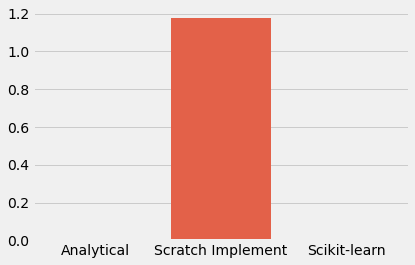

In [387]:
sns.barplot(x=['Analytical', 'Scratch Implement', 'Scikit-learn'],
            y=[analytical_solution_time, lr_raw_exec_time, sklearn_exec_time])
print(f"Analytic: {analytical_solution_time}")
print(f"Implement from scratch: {lr_raw_exec_time}")
print(f"Scikit-learn: {sklearn_exec_time}")

## MSE

In [388]:
print(f"MSE of Implement from scratch solution: {model_eval.get_report(lr_raw)}")
print(f"MSE of Scikit-learn solution: {model_eval.get_report(lr_sk)}")

MSE of Implement from scratch solution: 21.89533537882507
MSE of Scikit-learn solution: 21.894831181729202


<AxesSubplot:>

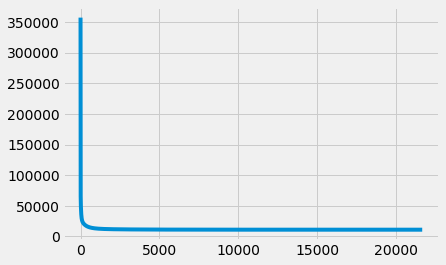

In [389]:
# Loss plotting

model_eval.loss_plot(lr_raw)

In [399]:
# Number of iterations

print(f"Number of iterations: {len(lr_raw.loss)}")

Number of iterations: 21651


---

# Logistic Regression

*   Dataset: breast cancer dataset
*   Objective: implement both numerical solution
*   PLot and check for convergence
*   Compare with Linear Regression using sklearn


#   Numerical solution:

* Loss function (Maximum Likelihood Estimator):
  $$
  \mathcal{L} (y,\hat{y}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i\cdot\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\right]
  $$

In [391]:
X, y = datasets.load_breast_cancer(return_X_y = True)
X = minmax_scaler.fit_transform(X)
X = np.insert(X, 0, 1, axis=1)
# X = minmax_scaler.fit_transform(X)

In [396]:
import numpy as np


class LogisticRegression:

    def __init__(self,
                 tol: float = 1e-6,
                 lr: float = 1e-2,
                 max_iteration: int = 1000) -> None:
        """Init hyperparameters

        Args:
            tol (float, optional): tolerance. Defaults to 1e-3.
            lr (float, optional): learning rate. Defaults to 5e-3.
            max_iteration (int, optional): maximum iteration. Defaults to 1000.
        """
        self.tol = tol
        self.lr = lr
        self.max_iteration = max_iteration

    def logistic_function(self, z):
        return 1 / (1 + np.exp(-z))

    def loss_function(self, X, y, beta):
        z = np.dot(X, beta)
        pred = self.logistic_function(z)
        return -np.mean(y * np.log(pred) + (1-y) * np.log(1 - pred))

    def get_gradient(self, X, y, beta):
        pred = self.logistic_function(np.dot(X, beta))
        diff = pred - y
        return diff.dot(X) / y.shape[0]

    def fit(self, X, y):
        beta = np.zeros(X.shape[1])
        loss = [self.loss_function(X, y, beta)]

        for i in range(1, self.max_iteration + 1):
            grad = self.get_gradient(X, y, beta)
            beta = beta - self.lr * grad
            current_loss = self.loss_function(X, y, beta)
            last_loss = loss[-1]
            loss.append(current_loss)
            if np.abs(last_loss - current_loss) < self.tol:
                break
        self.beta = beta
        self.loss = loss

    def predict(self, X):
        z = np.dot(X, self.beta)
        pred = self.logistic_function(z)
        return pred > 0.5


In [397]:
clf = LogisticRegression(tol=1e-6, lr=5e-2, max_iteration=10000)
clf.fit(X, y)

2.7336480617523193
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       212
           1       0.96      0.99      0.98       357

    accuracy                           0.97       569
   macro avg       0.97      0.96      0.97       569
weighted avg       0.97      0.97      0.97       569



<AxesSubplot:>

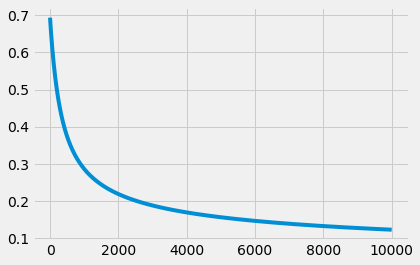

In [398]:
clf_eval = ModelEvaluation(X, y, model_type='clf')
print(clf_eval.executed_time(clf))
print(clf_eval.get_report(clf))
clf_eval.loss_plot(clf)

# Support Vector Machine


*   Dataset: breast cancer
*   Objective: understand how SVM work/ the effects of choosing kernels on dataset



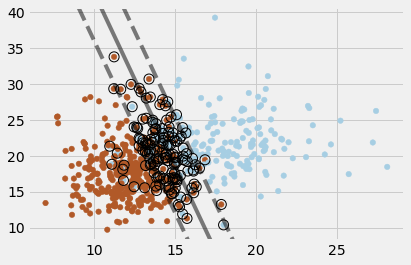

In [256]:
X, y = datasets.load_breast_cancer(return_X_y = True)
X = X[:,:2]

# fit the model, don't regularize for illustration purposes
clf = SVC(kernel='linear', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

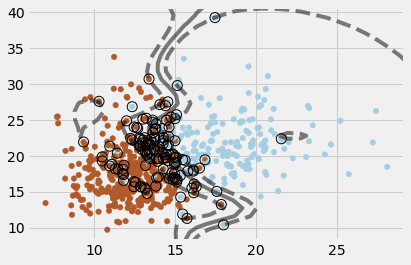

In [257]:
X, y = datasets.load_breast_cancer(return_X_y = True)
X = X[:,:2]

# fit the model, don't regularize for illustration purposes
clf = SVC(kernel='rbf', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

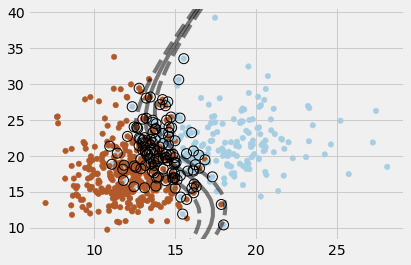

In [259]:
X, y = datasets.load_breast_cancer(return_X_y = True)
X = X[:,:2]

# fit the model, don't regularize for illustration purposes
clf = SVC(kernel='poly', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()